# Self-Driving Car Engineer Nanodegree


## Project: Advanced Lane Finding 
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import glob
from collections import deque

%matplotlib inline

## Useful functions from course
The great thing about this project was that most of the code was already provided and explained in the lessons. Most of the code works as it is and the only challenging part is tuning the various parameters. 

### Image Transformation Functions

In [2]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

def warper(img, src=None, dst=None, inverse=False):

    img_size = (img.shape[1], img.shape[0])
    if src is None:
        src = np.float32(
            [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 70), img_size[1] / 2 + 100]])
    if dst is None:
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    if not inverse:
        M = cv2.getPerspectiveTransform(src, dst)
    else: # This is actually the calculation of the inverse matrix, Minv.
        M = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

### Thesholding Functions

In [3]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output    

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output    

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

### Sliding Window Functions

In [4]:
def find_window_lanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 35
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        # cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        # cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return (leftx, lefty), (rightx, righty)

### Lane Detection and Polynomial Fitting

In [5]:
def fit_polynomial(leftx, lefty, rightx, righty):
    """Fit a second order polynomial to each array of lane points."""
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def generate_plot_points(src_img, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, src_img.shape[0] - 1, src_img.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    return ploty, left_fitx, right_fitx

def draw_window_lanes(src_img, leftx, lefty, rightx, righty, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty, left_fitx, right_fitx = generate_plot_points(src_img, left_fit, right_fit)

    out_img = np.dstack((src_img, src_img, src_img))*255
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig('./output_images/lanedetection_sliding_window.png')
    plt.show()
    
def draw_filled_lanes(undist, warped, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

### Predicting Lanes in Frames

In [6]:
def predict_lanes(img, left_fit, right_fit):
    """Retrieve lane lines based on existing best guess by find_window_lanes."""
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) & (
        nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) & (
        nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return (leftx, lefty), (rightx, righty)

def draw_predicted_lanes(img, leftx, lefty, rightx, righty, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty, left_fitx, right_fitx = generate_plot_points(img, left_fit, right_fit)
    img = undistort_image(img)
    img = threshold_image(img)
    img = warp_image(img)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

### Radius of Curvature

In [7]:
def calculate_curvature(img, left_x, right_x, left_fit, right_fit):
    image_size = img.shape
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720 # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

    # Recalculate road curvature in X-Y space
    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_x * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_x * xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / \
                    np.absolute(2 * left_fit_cr[0])

    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / \
                     np.absolute(2 * right_fit_cr[0])

    left_intercept = left_fit[0] * image_size[0] ** 2 + left_fit[1] * image_size[0] + left_fit[2]
    right_intercept = right_fit[0] * image_size[0] ** 2 + right_fit[1] * image_size[0] + right_fit[2]
    
    calculated_center = (left_intercept + right_intercept) / 2.0
    vehicle_position = (calculated_center - image_size[1] / 2.0) * xm_per_pix
    
    return left_curverad, right_curverad, vehicle_position

### Sliding Window Search
This approach is not used in the project. But I would like to try it later.

In [8]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def sliding_window_search(warped):
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channle 
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()

## Build a Lane Finding Pipeline

### Camera Calibration
Here are the steps of camera calibration.

In [9]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'output_images/calibrated/' + fname.split(os.sep)[-1]
        cv2.imwrite(write_name, img)

#### Visualize Camera Corners

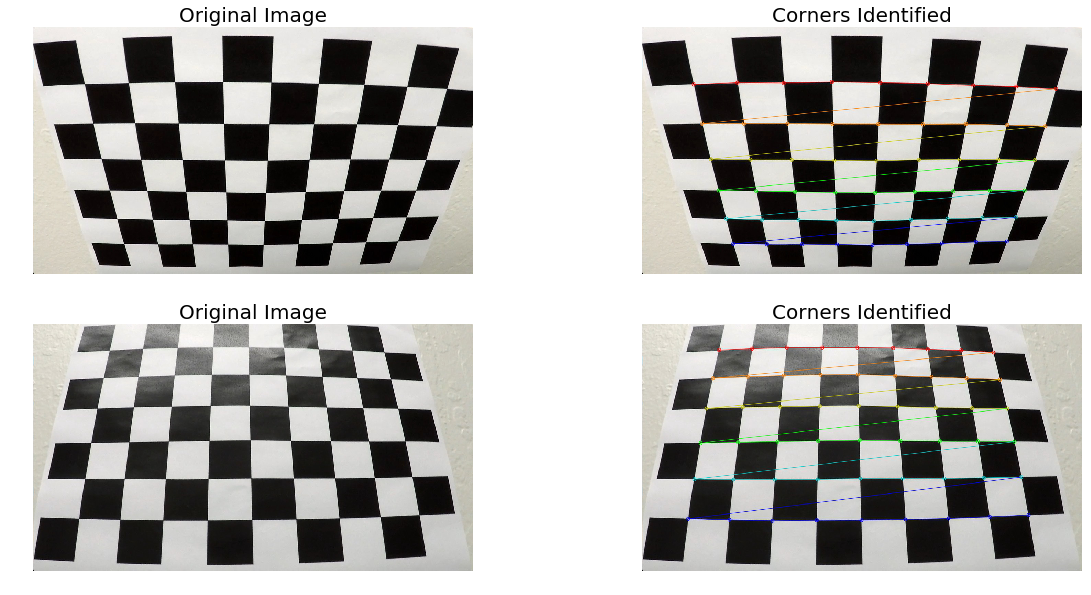

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(mpimg.imread('camera_cal/calibration2.jpg'))
axs[0].set_title('Original Image', fontsize=20)
axs[1].axis('off')
axs[1].imshow(mpimg.imread('output_images/calibrated/calibration2.jpg'))
axs[1].set_title('Corners Identified', fontsize=20)
axs[2].axis('off')
axs[2].imshow(mpimg.imread('camera_cal/calibration3.jpg'))
axs[2].set_title('Original Image', fontsize=20)
axs[3].axis('off')
axs[3].imshow(mpimg.imread('output_images/calibrated/calibration3.jpg'))
axs[3].set_title('Corners Identified', fontsize=20)

### Distortion Correction

In [11]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
calibration_result = {}
calibration_result["mtx"] = mtx
calibration_result["dist"] = dist

# Pipeline function
def undistort_image(img):
    return cv2.undistort(img, calibration_result["mtx"], calibration_result["dist"], None, calibration_result["mtx"])

# Test undistortion on an image
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = undistort_image(img)
    cv2.imwrite('output_images/undistorted/' + fname.split(os.sep)[-1], dst)

images = glob.glob('camera_cal/calibration*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = undistort_image(img)
    cv2.imwrite('output_images/undistorted/' + fname.split(os.sep)[-1], dst)    

#### Visualize Undistortion

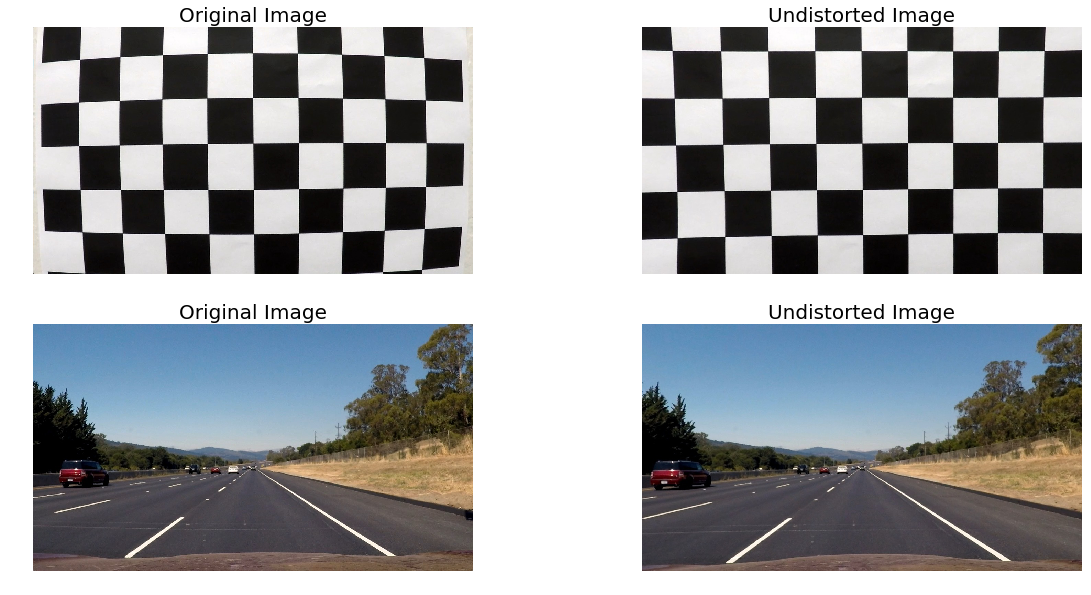

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(mpimg.imread('camera_cal//calibration1.jpg'))
axs[0].set_title('Original Image', fontsize=20)
axs[1].axis('off')
axs[1].imshow(mpimg.imread('output_images/undistorted/calibration1.jpg'))
axs[1].set_title('Undistorted Image', fontsize=20)
axs[2].axis('off')
axs[2].imshow(mpimg.imread('test_images/straight_lines2.jpg'))
axs[2].set_title('Original Image', fontsize=20)
axs[3].axis('off')
axs[3].imshow(mpimg.imread('output_images/undistorted/straight_lines2.jpg'))
axs[3].set_title('Undistorted Image', fontsize=20)

### Color and Gradient Threshold

In [13]:
def threshold_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = threshold_image(img)
    cv2.imwrite('output_images/thresholded/' + fname.split(os.sep)[-1], dst)

#### Visualize Color and Gradient Threshold

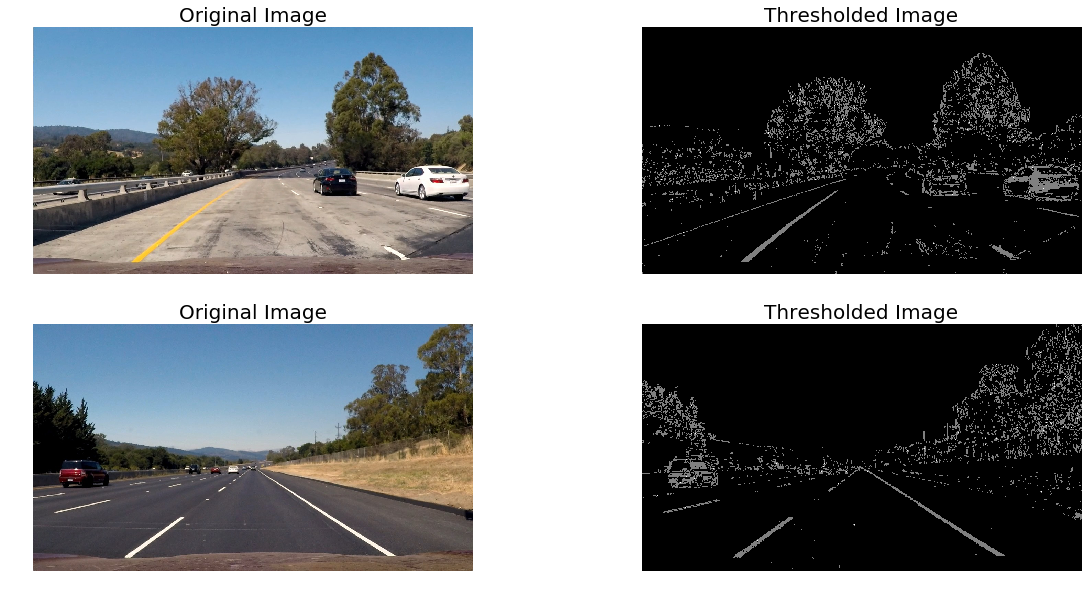

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(mpimg.imread('test_images/test1.jpg'))
axs[0].set_title('Original Image', fontsize=20)
axs[1].axis('off')
axs[1].imshow(mpimg.imread('output_images/thresholded/test1.jpg'), cmap='gray')
axs[1].set_title('Thresholded Image', fontsize=20)
axs[2].axis('off')
axs[2].imshow(mpimg.imread('test_images/straight_lines2.jpg'))
axs[2].set_title('Original Image', fontsize=20)
axs[3].axis('off')
axs[3].imshow(mpimg.imread('output_images/thresholded/straight_lines2.jpg'), cmap='gray')
axs[3].set_title('Thresholded Image', fontsize=20)

### Perspective Transform

In [15]:
# pipeline function
src = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
dst = np.float32([[303, 697], [303, 0], [1011, 0], [1011, 690]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def warp_image(img):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size)

images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = warp_image(img)
    cv2.imwrite('output_images/warped/' + fname.split(os.sep)[-1], dst)

#### Visualize Perspective Transform

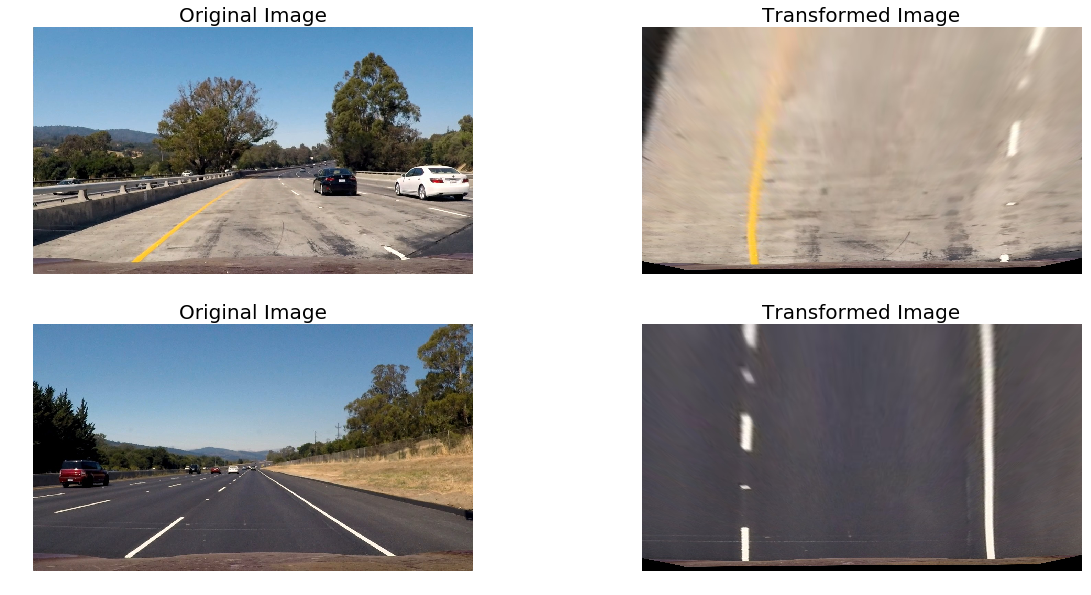

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(mpimg.imread('test_images/test1.jpg'))
axs[0].set_title('Original Image', fontsize=20)
axs[1].axis('off')
axs[1].imshow(mpimg.imread('output_images/warped/test1.jpg'))
axs[1].set_title('Transformed Image', fontsize=20)
axs[2].axis('off')
axs[2].imshow(mpimg.imread('test_images/straight_lines2.jpg'))
axs[2].set_title('Original Image', fontsize=20)
axs[3].axis('off')
axs[3].imshow(mpimg.imread('output_images/warped/straight_lines2.jpg'))
axs[3].set_title('Transformed Image', fontsize=20)

### Lane Detection

In [17]:
# Pipeline function
def detect_lanes(img, outputPath = None):
    undist = undistort_image(img)
    binary = threshold_image(undist)
    warped = warp_image(binary)
    
    (leftx, lefty), (rightx, righty) = find_window_lanes(warped)
    
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
    
    ploty, left_fitx, right_fitx = generate_plot_points(warped, left_fit, right_fit)
    
    if outputPath != None:
        out_img = np.dstack((warped, warped, warped))*255
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        plt.imshow(out_img)
        plt.axis('off')
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig(outputPath, dpi='figure', bbox_inches='tight', pad_inches = 0)
        
        plt.close()
        
    return ploty, left_fitx, right_fitx

images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    detect_lanes(img, 'output_images/detected_lines/' + fname.split(os.sep)[-1])

C:\Users\Nabeel\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#### Visualize Lanes Detected

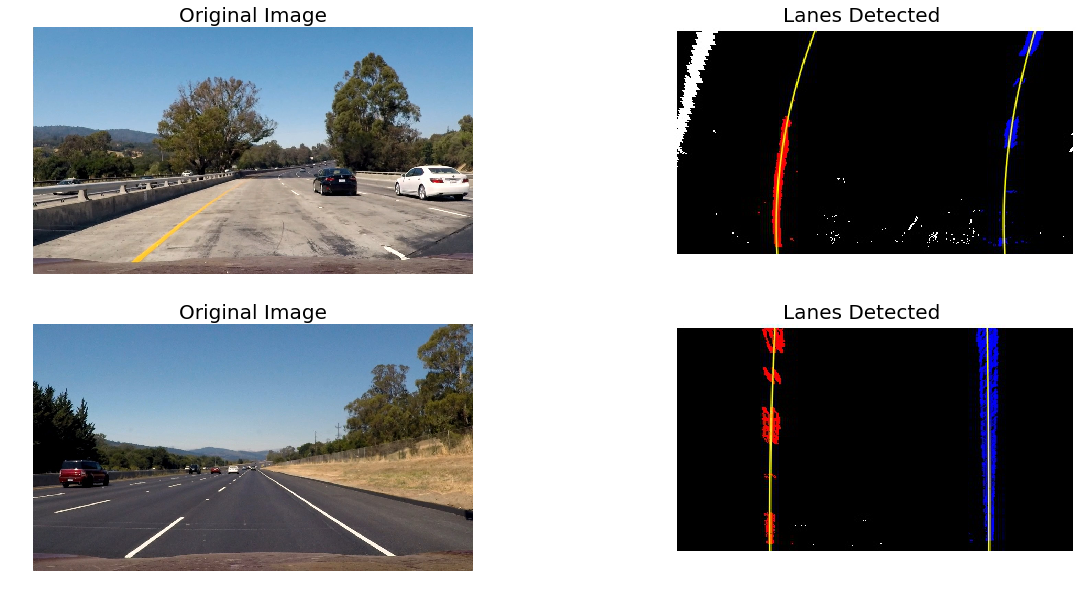

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(mpimg.imread('test_images/test1.jpg'))
axs[0].set_title('Original Image', fontsize=20)
axs[1].axis('off')
axs[1].imshow(mpimg.imread('output_images/detected_lines/test1.jpg'))
axs[1].set_title('Lanes Detected', fontsize=20)
axs[2].axis('off')
axs[2].imshow(mpimg.imread('test_images/straight_lines2.jpg'))
axs[2].set_title('Original Image', fontsize=20)
axs[3].axis('off')
axs[3].imshow(mpimg.imread('output_images/detected_lines/straight_lines2.jpg'))
axs[3].set_title('Lanes Detected', fontsize=20)

### Radius Of Curvature

In [19]:
# Pipeline function
def radius_of_curvature(img):
    undist = undistort_image(img)
    binary = threshold_image(undist)
    warped = warp_image(binary)
    
    (leftx, lefty), (rightx, righty) = find_window_lanes(warped)
    
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
    
    ploty, left_fitx, right_fitx = generate_plot_points(warped, left_fit, right_fit)
    
    left_curvature, right_curvature, vehicle_position = calculate_curvature(img, left_fitx, right_fitx, left_fit, right_fit)
    
    result = np.copy(img)

    curvature_text = 'Left Curvature: {:.2f} m Right Curvature: {:.2f} m Position: {:.2f} m '.format(left_curvature, right_curvature, vehicle_position)
    cv2.putText(result, curvature_text, (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    return result
    
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = radius_of_curvature(img)  
    cv2.imwrite('output_images/radius_curvature/' + fname.split(os.sep)[-1], dst)

C:\Users\Nabeel\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#### Visualize Radious of Curvature

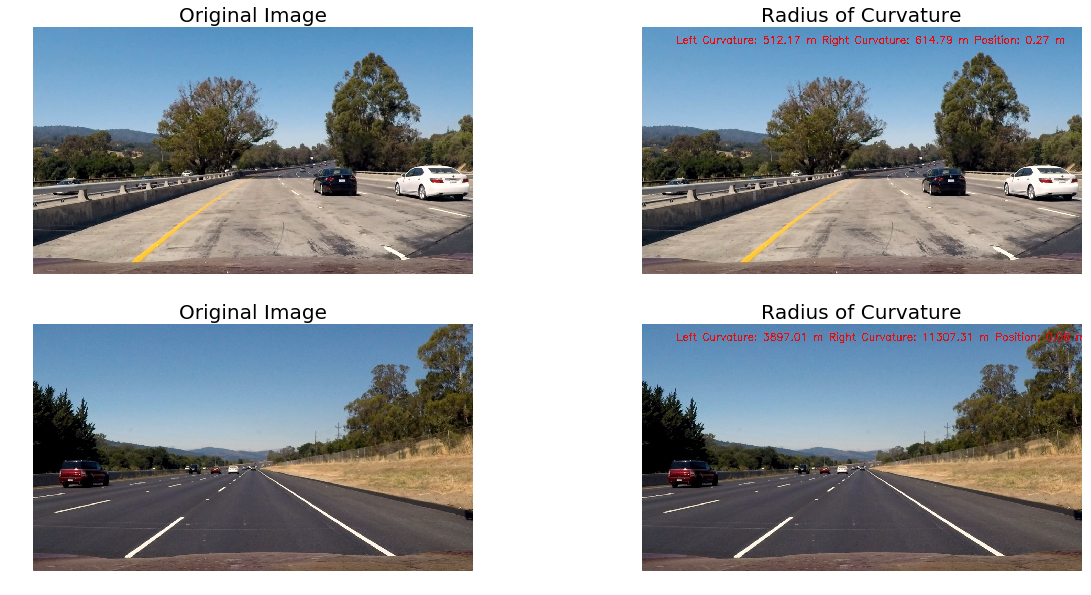

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(mpimg.imread('test_images/test1.jpg'))
axs[0].set_title('Original Image', fontsize=20)
axs[1].axis('off')
axs[1].imshow(mpimg.imread('output_images/radius_curvature/test1.jpg'))
axs[1].set_title('Radius of Curvature', fontsize=20)
axs[2].axis('off')
axs[2].imshow(mpimg.imread('test_images/straight_lines2.jpg'))
axs[2].set_title('Original Image', fontsize=20)
axs[3].axis('off')
axs[3].imshow(mpimg.imread('output_images/radius_curvature/straight_lines2.jpg'))
axs[3].set_title('Radius of Curvature', fontsize=20)

### Final Result

In [21]:
# Pipeline function
def process_image(img):
    undist = undistort_image(img)
    binary = threshold_image(undist)
    warped = warp_image(binary)
    
    (leftx, lefty), (rightx, righty) = find_window_lanes(warped)
    
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
    
    ploty, left_fitx, right_fitx = generate_plot_points(warped, left_fit, right_fit)
    
    left_curvature, right_curvature, vehicle_position = calculate_curvature(img, left_fitx, right_fitx, left_fit, right_fit)
    
    result = draw_filled_lanes(undist, warped, left_fitx, right_fitx, ploty)

    curvature_text = 'Left Curvature: {:.2f} m Right Curvature: {:.2f} m Position: {:.2f} m '.format(left_curvature, right_curvature, vehicle_position)
    cv2.putText(result, curvature_text, (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    return result

images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = process_image(img)
    cv2.imwrite('output_images/final_result/' + fname.split(os.sep)[-1], dst)

C:\Users\Nabeel\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#### Visualize Final Output

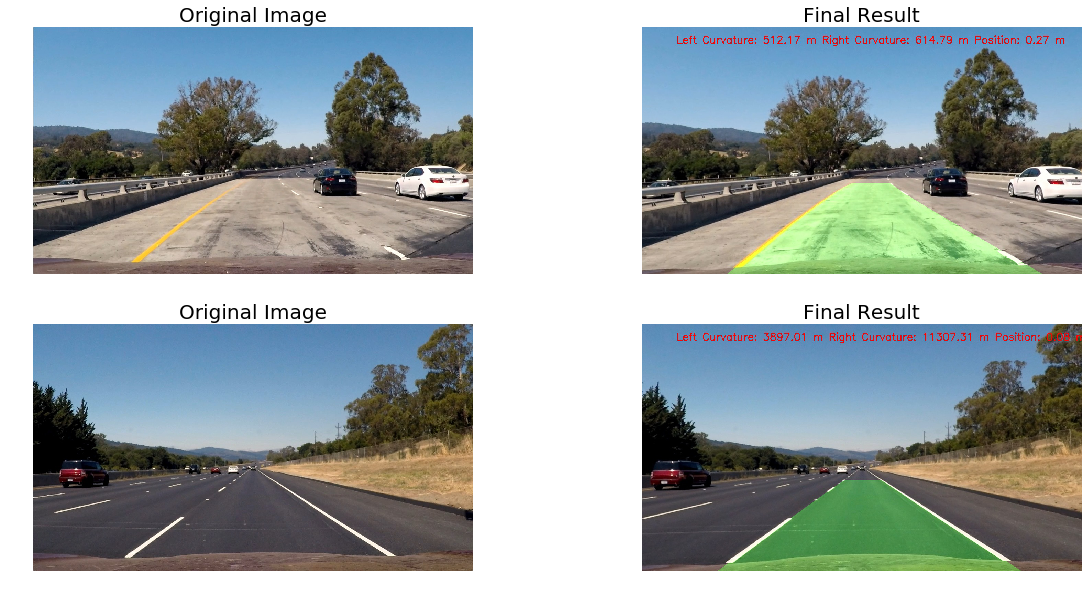

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(mpimg.imread('test_images/test1.jpg'))
axs[0].set_title('Original Image', fontsize=20)
axs[1].axis('off')
axs[1].imshow(mpimg.imread('output_images/final_result/test1.jpg'))
axs[1].set_title('Final Result', fontsize=20)
axs[2].axis('off')
axs[2].imshow(mpimg.imread('test_images/straight_lines2.jpg'))
axs[2].set_title('Original Image', fontsize=20)
axs[3].axis('off')
axs[3].imshow(mpimg.imread('output_images/final_result/straight_lines2.jpg'))
axs[3].set_title('Final Result', fontsize=20)


## Video Pipeline

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted_left = deque([], 10)
        self.recent_xfitted_right = deque([], 10)
        #polynomial coefficients averaged over the last n iterations
        self.best_left_fit = None  
        self.best_right_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def process_image(self, image):
        image = np.copy(image)
        size = (image.shape[1], image.shape[0])
        undist = undistort_image(image)
        binary = threshold_image(undist)
        warped = warp_image(binary)
        
        if self.detected == False:
            (leftx, lefty), (rightx, righty) = find_window_lanes(warped)
            left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
            ploty, left_fitx, right_fitx = generate_plot_points(warped, left_fit, right_fit)
            self.best_left_fit = left_fit
            self.best_right_fit = right_fit
            self.detected = True
        else:
            (leftx, lefty), (rightx, righty) = predict_lanes(warped, self.best_left_fit, self.best_right_fit)
            left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
            ploty, left_fitx, right_fitx = generate_plot_points(warped, left_fit, right_fit)
            self.best_left_fit = left_fit
            self.best_right_fit = right_fit

        result = draw_filled_lanes(undist, warped, left_fitx, right_fitx, ploty)

        self.recent_xfitted_left.append(left_fitx)
        self.recent_xfitted_right.append(right_fitx)
        ave_left = np.average(self.recent_xfitted_left, axis=0)
        ave_right = np.average(self.recent_xfitted_right, axis=0)
        
        left_curvature, right_curvature, vehicle_position = calculate_curvature(image, ave_left, ave_right, self.best_left_fit, self.best_right_fit)
        
        curvature_text = 'Left Curvature: {:.2f} m Right Curvature: {:.2f} m Position: {:.2f} m '.format(left_curvature, right_curvature, vehicle_position)

        cv2.putText(result, curvature_text, (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        return result

Here's the pipeline applied to project video.

In [26]:
line = Line()
project_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(line.process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:48<00:00,  4.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 4min 50s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

Here's the pipeline applied to challenge video.

In [28]:
line = Line()
challenge_output = 'output_videos/challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(line.process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [01:42<00:00,  4.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 1min 44s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

Here's the pipeline applied to harder challenge video.

In [30]:
line = Line()
harder_challenge_output = 'output_videos/harder_challenge_video.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
harder_challenge_clip = clip1.fl_image(line.process_image) #NOTE: this function expects color images!!
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [05:39<00:00,  4.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

Wall time: 5min 42s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))